In [2]:
import pandas as pd
import numpy as np
import math
import string
import copy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from collections import Counter
from tqdm import tqdm
from tensorflow_addons.metrics import F1Score
import warnings
import os
warnings.filterwarnings("ignore")

In [42]:
test_folds = {}

In [43]:
stfold = StratifiedKFold(n_splits=5, shuffle=True)
train_l = list()
val_l = list()
test_l = list()
maxlen = 100
cnt = 0
for train_index, test_index in stfold.split(data['comment'], data['label']):
    cnt += 1
    train = data.iloc[train_index]
    train_x, train_y = train['comment'], train['label']
    tmp = data.iloc[test_index]

    val, test = train_test_split(tmp, test_size=0.5, stratify=tmp['label'])    
    val_x, val_y = val['comment'], val['label']
    test_x, test_y = test['comment'], test['label']    
    
    train_x = keras.preprocessing.sequence.pad_sequences(train_x, maxlen=maxlen)
    val_x = keras.preprocessing.sequence.pad_sequences(val_x, maxlen=maxlen)
    test_x = keras.preprocessing.sequence.pad_sequences(test_x, maxlen=maxlen)
    
    embed_dim = 128  # Embedding size for each token
    vocab_size = n_word_unique + 1
    test_folds[cnt] = (test_x, test_y)
    
    inputs = layers.Input(shape=(maxlen, ))
    embedding_layer = layers.Embedding(input_dim = vocab_size, output_dim = embed_dim, input_length=maxlen)
    x = embedding_layer(inputs)
    x = layers.Bidirectional(layers.GRU(64, return_sequences = True))(x)
    x = layers.Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
    x = layers.Dropout(0.3)(x)
    avg_pool = layers.GlobalAveragePooling1D()(x)
    max_pool = layers.GlobalMaxPooling1D()(x)
    x = layers.concatenate([avg_pool, max_pool])
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model_path = "sigmoid_models/{itr:04}/".format(itr=cnt)
    checkpoint_path = model_path + "{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    !mkdir sigmoid_models
    !mkdir $model_path
    
    
    model.compile('adam', "binary_crossentropy", metrics=["accuracy", 
                                                          tf.keras.metrics.AUC(name='auc')])
    
    
    #create checkpoint to save model
    #with best validation loss
    model.save_weights(checkpoint_path.format(epoch=0))

    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_auc', verbose=1,
            save_weights_only=True, save_best_only=True, mode='max')
    
    history = model.fit(
                        train_x, train_y, 
                        batch_size=128, epochs=10, 
                        validation_data=(val_x, val_y),
                        callbacks = [checkpoint]
                        )

    latest = tf.train.latest_checkpoint(checkpoint_dir)
    model.load_weights(latest)
    
    train_eval = model.evaluate(train_x, train_y)
    val_eval = model.evaluate(val_x, val_y)
    test_eval = model.evaluate(test_x, test_y)
    
    test_l.append(test_eval)
    val_l.append(val_eval)
    train_l.append(train_eval)

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 0.6316 - accuracy: 0.6323 - auc: 0.7126
Epoch 00001: val_auc improved from -inf to 0.90046, saving model to sigmoid_models/0001/0001.ckpt
63/63 [==============================] - 13s 210ms/step - loss: 0.6316 - accuracy: 0.6323 - auc: 0.7126 - val_loss: 0.4242 - val_accuracy: 0.8240 - val_auc: 0.9005
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.1905 - accuracy: 0.9356 - auc: 0.9786
Epoch 00002: val_auc improved from 0.90046 to 0.94529, saving model to sigmoid_models/0001/0002.ckpt
63/63 [==============================] - 12s 193ms/step - loss: 0.1905 - accuracy: 0.9356 - auc: 0.9786 - val_loss: 0.2904 - val_accuracy: 0.8820 - val_auc: 0.9453
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.0282 - accuracy: 0.9936 - auc: 0.9990
Epoch 00003: val_auc did not improve from 0.94529
63/63 [==============================] - 12s 188ms/step - loss: 0.0282 - accuracy: 0.9936 - auc: 0.

In [44]:
test_l = np.array(test_l)
val_l = np.array(val_l)
train_l = np.array(train_l)

print("test avg loss: ", np.mean(test_l[:, 0]), "+/-" ,np.std(test_l[:, 0]))
print("test avg acc: ", np.mean(test_l[:, 1]),  "+/-" ,np.std(test_l[:, 1]))
print("test avg auc: ", np.mean(test_l[:, 2]),  "+/-" ,np.std(test_l[:, 2]))

print('\n')


print("val avg loss: ", np.mean(val_l[:, 0]), "+/-" ,np.std(val_l[:, 0]))
print("val avg acc: ", np.mean(val_l[:, 1]),  "+/-" ,np.std(val_l[:, 1]))
print("val avg auc: ", np.mean(val_l[:, 2]),  "+/-" ,np.std(val_l[:, 2]))


print('\n')


print("train avg loss: ", np.mean(train_l[:, 0]), "+/-" ,np.std(train_l[:, 0]))
print("train avg acc: ", np.mean(train_l[:, 1]),  "+/-" ,np.std(train_l[:, 1]))
print("train avg auc: ", np.mean(train_l[:, 2]),  "+/-" ,np.std(train_l[:, 2]))

test avg loss:  0.33402326703071594 +/- 0.03462371045235583
test avg acc:  0.8819999933242798 +/- 0.008197564137779105
test avg auc:  0.9388038992881775 +/- 0.007758189779532449


val avg loss:  0.3330051422119141 +/- 0.035920337702291374
val avg acc:  0.8824000000953675 +/- 0.004454199106389449
val avg auc:  0.9386636018753052 +/- 0.004720971465924061


train avg loss:  0.04283520660828799 +/- 0.0328788888044599
train avg acc:  0.993625009059906 +/- 0.005748376787211271
train avg auc:  0.9991953372955322 +/- 0.0008387386695293788


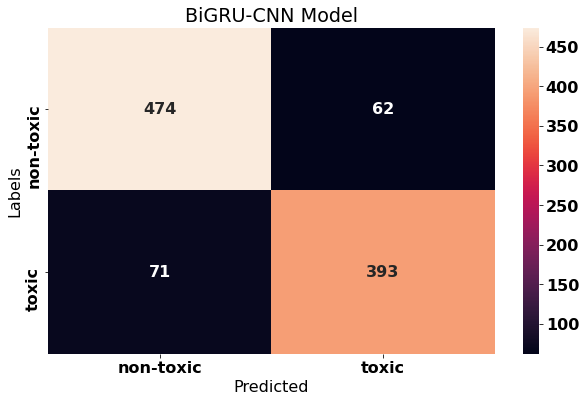

In [45]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd 
from sklearn.metrics import confusion_matrix

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)
pred = np.array([model.predict(test_folds[5][0]) > 0.5], dtype=int).ravel()
cm = confusion_matrix(test_folds[5][1].values, pred)
cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (10, 6))

sns.heatmap(cm,
            fmt = 'd',
            annot=True)


ax = plt.subplot()
ax.set_xlabel('Predicted')
ax.set_ylabel('Labels')
ax.xaxis.set_ticklabels(['non-toxic', 'toxic'])
ax.yaxis.set_ticklabels(['non-toxic', 'toxic'])
ax.set_title('BiGRU-CNN Model')
plt.show()